In [ ]:
# Ran with predictors_simple kernel
# Python 3.10.8

import numpy as np # 1.26.4
import pandas as pd # 2.2.3
import tensorflow as tf # 2.10.0
import matplotlib # 3.10.3
import torch # 2.0.0

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt

from joblib import load
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns
import re

import os

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction/Model")
from ADModel_three_state import ADModel_three_state_abund
from ADModel_two_state import ADModel_two_state_abund
from Data import DataReader, SplitData, FastTensorDataLoader, one_hot_encode


os.chdir("/Users/claireleblanc/Documents/tools_software/adhunter")
from actpred.models import ActCNNSystem

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction")

In [ ]:
# Parameters to make figures work better with illustrator 
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

In [168]:
# Reading in the full length sequences and tile data

data = pd.read_csv("Data/Unique_502_Gcn4_Seqs_three_clusters.csv", index_col=0)
test_seqs= data[data["heirarchical"] == 1]
val_seqs= data[data["heirarchical"] == 2]
train_seqs = data[data["heirarchical"] == 3]

tile_data = pd.read_csv("Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")

activity_dict = {}
for i in tile_data.index:
    activity_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"activity"]

abund_dict = {}
for i in tile_data.index:
    abund_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"abundance"]

used_tiles = []

def get_tile_activity(tile):
    used_tiles.append(tile)
    return activity_dict.get(tile)

def get_tile_abundance(tile):
    return abund_dict.get(tile)


# Break full length seqs into tiles, adding in the final tile
test_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in test_seqs["Sequence"]]
test_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in test_seqs["Sequence"]]
test_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in test_seqs["40_tiles"]]
test_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in test_seqs["40_tiles"]]

val_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in val_seqs["Sequence"]]
val_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in val_seqs["Sequence"]]
val_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]
val_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]

train_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in train_seqs["Sequence"]]
train_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]
train_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]

unused_tiles = list(set(tile_data["aa_seq"]).difference(set(used_tiles)))
other_tiles = pd.DataFrame(unused_tiles, columns=["aa_seq"])
other_tiles["activity"] = [get_tile_activity(s) for s in other_tiles["aa_seq"]]
other_tiles["abundance"] = [get_tile_abundance(s) for s in other_tiles["aa_seq"]]


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_811/975632502.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in test_seqs["Sequence"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_811/975632502.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in test_seqs["Sequence"]]
/var/folders/34/1pw3

In [ ]:
# This was used to create fasta file for ADPred, TADA predictions
with open("Data/tile_data_wrangled.fasta", "w+") as f:
    for i in tile_data.index:
        f.write(">" + "seq" + str(i) + "\n")
        f.write(tile_data.loc[i, "aa_seq"] + "\n")

In [ ]:
# This was used to create 53aa tiles for PADDLE prediction
with open("Data/tile_data_wrangled_53mer.fasta", "w+") as f:
    for i in tile_data.index:
        f.write(">" + "seq" + str(i) + "\n")
        f.write("SHLATAGSTSSAS" + tile_data.loc[i, "aa_seq"] + "\n")

In [ ]:
# For two state model:
# This is an attempt to choose the "best" model in an unbiased way
# Specifically, it tries to choose a model that has both a high pearson and a high spearman correlation
# It does this by choosing the model with the highest combined spearman and pearson rank

two_model_results = pd.read_csv("results/results_two_state_test_larger_LR.csv")

two_model_results = two_model_results.sort_values("pearson_act_val", ascending=False)
two_model_results = two_model_results.reset_index()
two_model_results["r1"] = two_model_results.index

two_model_results = two_model_results.sort_values("spearman_act_val", ascending=False)
two_model_results = two_model_results.reset_index()
two_model_results["r2"] = two_model_results.index
two_model_results = two_model_results.drop(columns="level_0")


two_model_results["max_rank"] = two_model_results[["r1","r2",]].max(axis=1)            # min–max rule
two_model_results["sum_rank"] = two_model_results["r1"] + two_model_results["r2"]               # Borda

In [ ]:
# For three state model:
# This is an attempt to choose the "best" model in an unbiased way
# Specifically, it tries to choose a model that has both a high pearson and a high spearman correlation
# It does this by choosing the model with the highest combined spearman and pearson rank

three_model_results = pd.read_csv("results/results_three_state_abund_test_larger_LR.csv")

three_model_results = three_model_results.sort_values("pearson_act_val", ascending=False)
three_model_results = three_model_results.reset_index()
three_model_results["r1"] = three_model_results.index

three_model_results = three_model_results.sort_values("spearman_act_val", ascending=False)
three_model_results = three_model_results.reset_index()
three_model_results["r2"] = three_model_results.index
three_model_results = three_model_results.drop(columns="level_0")


three_model_results["max_rank"] = three_model_results[["r1","r2"]].max(axis=1)            # min–max rule
three_model_results["sum_rank"] = three_model_results["r1"] + three_model_results["r2"]                  # Borda

three_model_results.sort_values(["sum_rank"])

,index,model_name,model_type,kernel_size,activity_fun,negative_pen,weight_pen,hill_value,spearman_abund_test,spearman_act_test,...,pearson_act_train,K1_negative,K2_negative,abund_negative,relu,total_params,r1,r2,max_rank,sum_rank
3,149,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,40,Linear,0.1,0.5,1,0.528212,0.780547,...,0.864056,True,False,False,False,1752,1,3,3,4
0,353,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,40,Linear,0.1,0.5,1,0.570910,0.792821,...,0.855837,True,False,False,False,2227,5,0,5,5
1,35,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,40,Linear,0.1,0.5,1,0.555066,0.788572,...,0.861137,True,False,False,False,2417,20,1,20,21
16,542,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,15,Hill,0.1,0.5,1,0.534824,0.796174,...,0.862499,False,False,False,False,802,16,16,16,32
35,511,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,10,Hill,0.1,0.5,1,0.567114,0.794963,...,0.866473,False,False,False,False,707,0,35,35,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,234,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,5,Linear,0.1,0.5,1,0.568715,0.697271,...,0.668522,False,False,False,False,707,699,621,699,1320
635,351,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,20,Linear,0.1,0.5,1,0.568307,0.695576,...,0.666353,False,False,False,False,1467,697,635,697,1332
654,30,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,5,Linear,0.1,0.5,1,0.559738,0.679931,...,0.659155,False,False,False,False,1087,702,654,702,1356
682,247,../../model_data/three_state_abundmodel_b10_e2...,three_state_abund,10,Linear,0.1,0.5,1,0.564101,0.680523,...,0.656957,False,False,False,False,1277,706,682,706,1388


In [ ]:
# Running the two-state biophysical model on the data

# Biophysical model parameters
size = (1,40,20)
hill_value = 1
relu = False
outchannel = 1

# Loading the "best" model, as defined above based on val data
# We also are filtering to use Hill value as that gave systematically better pearson correlations
best_two_model_row = two_model_results[two_model_results["activity_fun"] == "Hill"].sort_values("sum_rank", ascending=True).reset_index()
model = best_two_model_row.loc[0, "model_name"].removeprefix("../../")
kernel_size_two = best_two_model_row.loc[0, "kernel_size"]
abund_k_two = int(re.search(r'ak(\d+)',model).group(1))
activity_fun = best_two_model_row.loc[0, "activity_fun"]

two_state_biophysical_model = ADModel_two_state_abund(size,activity_fun, kernel_size_two, relu=False, abund_k=abund_k_two)
two_state_biophysical_model.load_state_dict(torch.load(f"{model}.pth"))

two_state_biophysical_model.eval()

# Loading the scaler
sc_act = load("Model/scaler_activity.bin")
sc_abund = load("Model/scaler_activity.bin")


def run_biophysical_model(loaded_model,sequence):
    """
    Takes a sequence and run the model on sequence
    """
    encoded_seq = one_hot_encode(sequence).reshape(1,1,40,20)
    seq_tensor = torch.from_numpy(encoded_seq).type(torch.FloatTensor)
    predictions = loaded_model(seq_tensor)
    predictions_act = sc_act.inverse_transform(predictions.detach().numpy().reshape(-1)[1].reshape(1,-1))
    predictions_abund = sc_abund.inverse_transform(predictions.detach().numpy().reshape(-1)[0].reshape(1,-1))
    return predictions_abund, predictions_act

# Run biophysical model on all the sequences
test_seqs["biophysics_gfp_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in tiles] for tiles in test_seqs["40_tiles"]]
val_seqs["biophysics_gfp_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_gfp_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_gfp_pred_2"] = [run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in other_tiles["aa_seq"]]

test_seqs["biophysics_mcherry_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[0] for tile in tiles] for tiles in test_seqs["40_tiles"]]
val_seqs["biophysics_mcherry_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_mcherry_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[0] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_mcherry_pred_2"] = [run_biophysical_model(two_state_biophysical_model, tile)[0] for tile in other_tiles["aa_seq"]]


/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_811/418284973.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["biophysics_gfp_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in tiles] for tiles in test_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80

In [ ]:
# Running the three state biophysical model on the data

# Biophysical model parameters
size = (1,40,20)
hill_value = 1
relu = False
outchannel = 1

# Loading the "best" model, as defined above based on val data
# We also are filtering to use Hill value as that gave systematically better pearson correlations
best_three_model_row = three_model_results[three_model_results["activity_fun"] == "Hill"].sort_values("sum_rank", ascending=True).reset_index()
model = best_three_model_row.loc[0, "model_name"].removeprefix("../../")
kernel_size_three = best_three_model_row.loc[0, "kernel_size"]
abund_k_three = int(re.search(r'ak(\d+)',model).group(1))
activity_fun = best_three_model_row.loc[0, "activity_fun"]

three_state_biophysical_model = ADModel_three_state_abund(size,activity_fun, kernel_size_three, relu=False, abund_k=abund_k_three)
three_state_biophysical_model.load_state_dict(torch.load(f"{model}.pth"))

three_state_biophysical_model.eval()

# Run model on all the sequences
test_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in tiles] for tiles in test_seqs["40_tiles"]]
val_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_gfp_pred_3"] = [run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in other_tiles["aa_seq"]]

test_seqs["biophysics_mcherry_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[0] for tile in tiles] for tiles in test_seqs["40_tiles"]]
val_seqs["biophysics_mcherry_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_mcherry_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[0] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_mcherry_pred_3"] = [run_biophysical_model(three_state_biophysical_model, tile)[0] for tile in other_tiles["aa_seq"]]



/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_811/3757141510.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in tiles] for tiles in test_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_811/3757141510.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1] fo

# Evaluating model performance

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


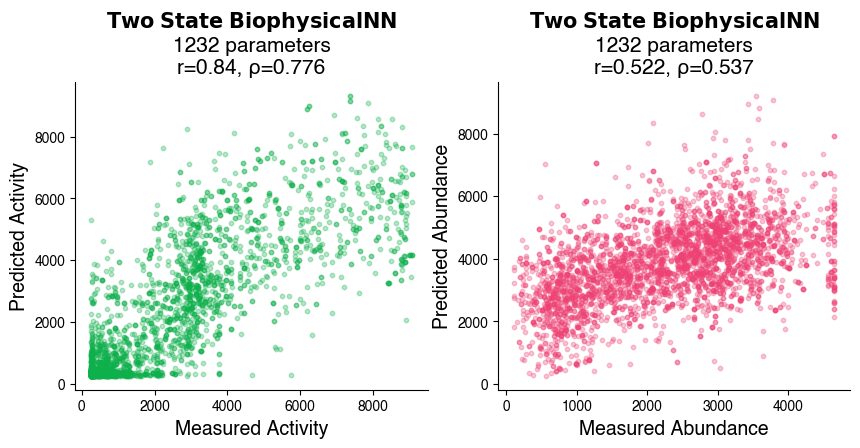

In [ ]:
# Code to plot scatter plots for two-state BiophysicalNN, and ADHunter

fig, axs = plt.subplots(1,2,figsize=(10,4))

# Scatter plot for two-state BiophysicalNN - GFP
tiles = [i for ls in test_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in test_seqs["40_tiles_exp_activities"] for i in ls]
actual = actual + (list(other_tiles["activity"]))
pred = [i for ls in test_seqs["biophysics_gfp_pred_2"] for i in ls]
pred = pred + (list(other_tiles["biophysics_gfp_pred_2"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[0].scatter(actual, pred, color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = pearsonr(plotting_data["actual"].astype('float'), plotting_data["pred"].astype('float')).correlation#np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] ** 2
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_title(r"$\bf{Two}$ $\bf{State}$ $\bf{BiophysicalNN}$" + f'\n1232 parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

# Scatter plot for two-state BiophysicalNN - mCherry
tiles = [i for ls in test_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in test_seqs["40_tiles_exp_abundance"] for i in ls]
actual = actual + (list(other_tiles["abundance"]))
pred = [i for ls in test_seqs["biophysics_mcherry_pred_2"] for i in ls]
pred = pred + (list(other_tiles["biophysics_mcherry_pred_2"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[1].scatter(actual, pred, color='#EE4274', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = pearsonr(plotting_data["actual"].astype('float'), plotting_data["pred"].astype('float')).correlation#np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] ** 2
axs[1].set_xlabel('Measured Abundance', fontsize=14)
axs[1].set_ylabel('Predicted Abundance', fontsize=14)
axs[1].set_title(r"$\bf{Two}$ $\bf{State}$ $\bf{BiophysicalNN}$" + f'\n1232 parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

sns.despine()
plt.savefig("figures/two_state_scatter_plots.pdf", format='pdf', bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


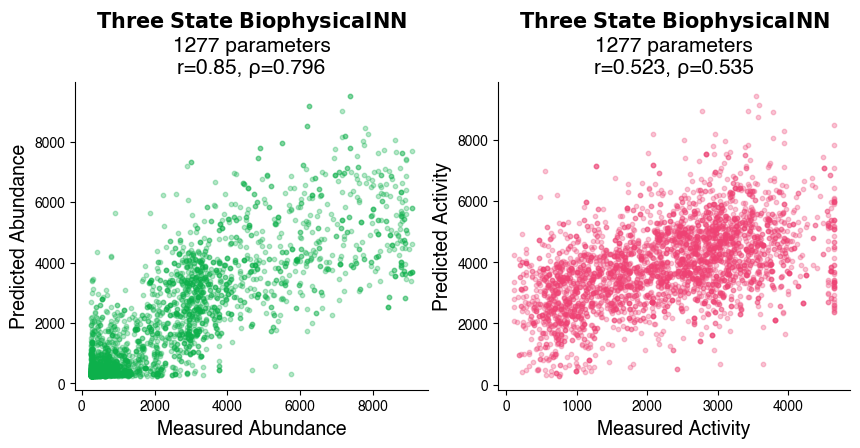

In [ ]:
# Code to plot scatter plots for three-state BiophysicalNN, and ADHunter

fig, axs = plt.subplots(1,2,figsize=(10,4))

# Scatter plot for three-state BiophysicalNN - GFP
tiles = [i for ls in test_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in test_seqs["40_tiles_exp_abundance"] for i in ls]
actual = actual + (list(other_tiles["abundance"]))
pred = [i for ls in test_seqs["biophysics_mcherry_pred_3"] for i in ls]
pred = pred + (list(other_tiles["biophysics_mcherry_pred_3"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

# Scatter plot for three-state BiophysicalNN - mCherry
axs[1].scatter(actual, pred, color='#EE4274', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = pearsonr(plotting_data["actual"].astype('float'), plotting_data["pred"].astype('float')).correlation#np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] ** 2
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_title(r"$\bf{Three}$ $\bf{State}$ $\bf{BiophysicalNN}$" + f'\n1277 parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

tiles = [i for ls in test_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in test_seqs["40_tiles_exp_activities"] for i in ls]
actual = actual + (list(other_tiles["activity"]))
pred = [i for ls in test_seqs["biophysics_gfp_pred_3"] for i in ls]
pred = pred + (list(other_tiles["biophysics_gfp_pred_3"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[0].scatter(actual, pred, color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = pearsonr(plotting_data["actual"].astype('float'), plotting_data["pred"].astype('float')).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] ** 2
axs[0].set_xlabel('Measured Abundance', fontsize=14)
axs[0].set_ylabel('Predicted Abundance', fontsize=14)
axs[0].set_title(r"$\bf{Three}$ $\bf{State}$ $\bf{BiophysicalNN}$" + f'\n1277 parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

sns.despine()
plt.savefig(f"figures/three_state_scatter_plots.pdf", format='pdf', bbox_inches='tight')

# Inspecting the parameters of the two-state BiophysicalNN

In [ ]:
# Order of AAs for plotting
amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

def get_conv_weights(model, layer): 
    """
    Extracts the convolutional layer weights and
    returns them as a pandas dataframe
    """
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer, kernel_size):
    """
    Extracts the linear layer weights and
    returns them as a numpy array. Also returns the 
    corresponding x-axis values
    """
    linear_weights = (40 - kernel_size + 1)
    model_state_dict = model.state_dict()
    linear_weight = model_state_dict[layer].detach().numpy().reshape(linear_weights)
    x_vals = np.array(range(0,linear_weights))
    return linear_weight, x_vals


In [ ]:
# This is setting up our colors for the plots

# Colors for convolutional filter
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Red, White, Blue
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any

# Colors for AA labels
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [ ]:
def make_row_plot_abund(fig, kernel_size, model, row, lim, height_ratios, num_rows, abund_kernel_size):
    """
    Core functionality for creating the convolutional filter plots. 
    Plots the convolution filter as a heatmap and the linear weights as a bar plot.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure object created with plt.figure
    
    kernel_size : int
        The size of the convolutional filter

    model : ADModel_abund
        Loaded model (from which parameters will be extracted)
    
    row : int
        Which row in the overall figure should we fill in

    lim : float
        The max value for the heatmap

    height_ratios : list
        Ratio of heights between rows, length should correspond to number of rows in
        gridspec object

    num_rows : list
        The number of rows in the gridspec object

    Returns
    -------
    ax1 : maplotlib.Axes object
        Contains the heatmap
    ax2 : maplotlib.Axes object
        Contains the barplot
    im1 : maplotlib.Axes.imshow object
        The heatmap
    """

    # Load the convolutional and linear weights for both NN blocks
    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    model_conv2 = get_conv_weights(model, "conv2.weight").T
    model_linear2, model_xvals2 = get_linear_weights(model, "linear2.weight", abund_kernel_size)

    # Calculate how much of the figure the convolutional filters vs. linear weights will take up
    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    ratio1_abund = abund_kernel_size
    ratio2_abund = 40 - abund_kernel_size + 1

    # GridSpec allows us to plot rows/columns with different dimensions
    # Here, we initalize the gridspec object with the total number of rows in our figure
    # But we only fill in the specific row that we are interested in
    # (When combined with many other gridspec objects, they will all line up and look good)
    gs1 = gridspec.GridSpec(2 + num_rows, 5, width_ratios=[ratio1, ratio2, 0.5, ratio1_abund, ratio2_abund], height_ratios=height_ratios, figure=fig)
    
    # axs are matplotlib axes
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])
    ax3 = plt.subplot(gs1[row, 3])
    ax4 = plt.subplot(gs1[row, 4])


    ## Code for first set of parameters --> K1 predictor
    # This is the code for plotting the convolutional filter as a heatmap
    # Min and max values of heatmap are passed by used
    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))

    # This is to color the amino acid labels
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax1.tick_params(axis='both', which='major', labelsize=6) 

    # This is the code for plotting the linear weights as a bar graph
    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    ## Code for second set of parameters --> abundance predictor
    # This is the code for plotting the convolutional filter as a heatmap
    # Min and max values of heatmap are passed by used
    im2 = ax3.imshow(model_conv2.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax3.set_yticks(range(len(model_conv2.index)), model_conv2.index)  # Label x-axis with column names
    ax3.set_xticks(np.arange(abund_kernel_size, step=2))
    
    # This is to color the amino acid labels
    for ytic in ax3.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax3.tick_params(axis='both', which='major', labelsize=6) 

    # This is the code for plotting the linear weights as a bar graph
    ax4.bar(model_xvals2, model_linear2, color="grey")
    ax4.spines["top"].set_visible(False)
    ax4.spines["left"].set_visible(False)
    ax4.spines["right"].set_visible(False)
    ax4.spines["bottom"].set_position('zero')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])


    return ax1, ax2, ax3, ax4, im1, im2


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


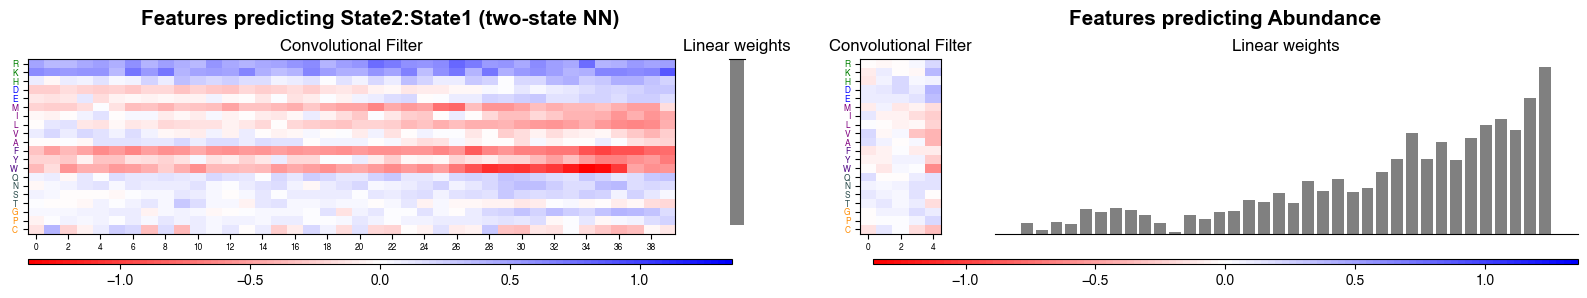

In [ ]:
# Get the range for the heatmaps
models = [two_state_biophysical_model]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())
    conv_weights += list(get_conv_weights(model, "conv2.weight").T.values.flatten())

# Max value for heatmaps
lim = max([abs(w) for w in conv_weights])

num_rows = 1

# Create a figure
fig = plt.figure(figsize=(20, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}

# We add in "padding" rows between the rows we care about
height_ratios = [.3] + [3.3]*num_rows + [.1]*2

# Create a gridspec object
gs1 = gridspec.GridSpec(3 + num_rows, 2, width_ratios=[1,1], height_ratios=height_ratios, figure=fig)

# Making the first row a title row
ax1 = plt.subplot(gs1[0,0])
ax1.set_title("Features predicting State2:State1 (two-state NN)", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax2 = plt.subplot(gs1[0,1])
ax2.set_title("Features predicting Abundance", fontdict=title_font)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.patch.set_visible(False)
ax2.axis('off')

# Adding the best NN parameters to the first row
ax1, ax2, ax3, ax4, im1, im2 = make_row_plot_abund(fig, kernel_size_two, two_state_biophysical_model, 1, lim, height_ratios, num_rows+1, abund_k_two)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)
ax3.set_title("Convolutional Filter", fontsize=12)
ax4.set_title("Linear weights", fontsize=12)

# Create another gridspec object to span the whole figure (1 column) to display the colorbar
gs_cb = gridspec.GridSpec(3 + num_rows, 2, width_ratios=[1,1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[2 + num_rows, 0])
cax2 = plt.subplot(gs_cb[2 + num_rows, 1])

# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')
fig.colorbar(im2, cax=cax2, orientation='horizontal')

plt.savefig('figures/two_state_parameters.pdf', dpi=1000, bbox_inches='tight')

# Making convolutional filter plots -> Three state

In [ ]:
# Same colors as before, not sure why I'm redefinint them here

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Red, White, Blue
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [ ]:
def make_row_plot_abund(fig, kernel_size, model, row, lim, height_ratios, num_rows, abund_kernel_size):
    """
    Core functionality for creating the convolutional filter plots. 
    Plots the convolution filter as a heatmap and the linear weights as a bar plot.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure object created with plt.figure
    
    kernel_size : int
        The size of the convolutional filter

    model : ADModel_abund
        Loaded model (from which parameters will be extracted)
    
    row : int
        Which row in the overall figure should we fill in

    lim : float
        The max value for the heatmap

    height_ratios : list
        Ratio of heights between rows, length should correspond to number of rows in
        gridspec object

    num_rows : list
        The number of rows in the gridspec object
    
    abund_kernel_size : int
        The size of the abundance kernel (can be different from other kernel sizes)

    Returns
    -------
    ax1-6 : maplotlib.Axes object
        Contains the heatmaps and barplots
    im1-3 : maplotlib.Axes.imshow object
        The heatmaps
    """

    # Load the parameters for the K1 module
    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    # Load the parameters for the K2 module
    model_conv2 = get_conv_weights(model, "conv2.weight").T
    model_linear2, model_xvals2 = get_linear_weights(model, "linear2.weight", kernel_size)

    # Load the parameters for the abundance module
    model_conv3 = get_conv_weights(model, "conv3.weight").T
    model_linear3, model_xvals3 = get_linear_weights(model, "linear3.weight", abund_kernel_size)

    # Calculate how much of the figure the convolutional filter vs. linear weights will take up
    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    ratio1_abund = abund_kernel_size
    ratio2_abund = 40 - abund_kernel_size + 1

    # GridSpec allows us to plot rows/columns with different dimensions
    # Here, we initalize the gridspec object with the total number of rows in our figure
    # But we only fill in the specific row that we are interested in
    # (When combined with many other gridspec objects, they will all line up and look good)
    gs1 = gridspec.GridSpec(2 + num_rows, 8, width_ratios=[ratio1, ratio2, 0.5, ratio1, ratio2, 0.5, ratio1_abund, ratio2_abund], height_ratios=height_ratios, figure=fig)
    
    # Maplotlib axes
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])
    ax3 = plt.subplot(gs1[row, 3])
    ax4 = plt.subplot(gs1[row, 4])
    ax5 = plt.subplot(gs1[row, 6])
    ax6 = plt.subplot(gs1[row, 7])

    # Plotting K1 heatmap
    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))

    # This is to color the amino acid labels
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax1.tick_params(axis='both', which='major', labelsize=6) 

    # Plotting K1 barplot
    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    # Plotting K2 heatmap
    im2 = ax3.imshow(model_conv2.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax3.set_yticks(range(len(model_conv2.index)), model_conv2.index)  # Label x-axis with column names
    ax3.set_xticks(np.arange(kernel_size, step=2))
    
    # Color the aa labels
    for ytic in ax3.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax3.tick_params(axis='both', which='major', labelsize=6) 

    # Plotting K2 bargraph
    ax4.bar(model_xvals2, model_linear2, color="grey")
    ax4.spines["top"].set_visible(False)
    ax4.spines["left"].set_visible(False)
    ax4.spines["right"].set_visible(False)
    ax4.spines["bottom"].set_position('zero')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])

    # Plotting abundance heatmap
    im3 = ax5.imshow(model_conv3.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax5.set_yticks(range(len(model_conv3.index)), model_conv3.index)  # Label x-axis with column names
    ax5.set_xticks(np.arange(abund_kernel_size, step=2))

    # Changing aa label color
    for ytic in ax5.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax5.tick_params(axis='both', which='major', labelsize=6) 

    # Plotting abundance bar graph
    ax6.bar(model_xvals3, model_linear3, color="grey")
    ax6.spines["top"].set_visible(False)
    ax6.spines["left"].set_visible(False)
    ax6.spines["right"].set_visible(False)
    ax6.spines["bottom"].set_position('zero')
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax6.set_xticklabels([])
    ax6.set_yticklabels([])

    return ax1, ax2, ax3, ax4, ax5, ax6, im1, im2, im3

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


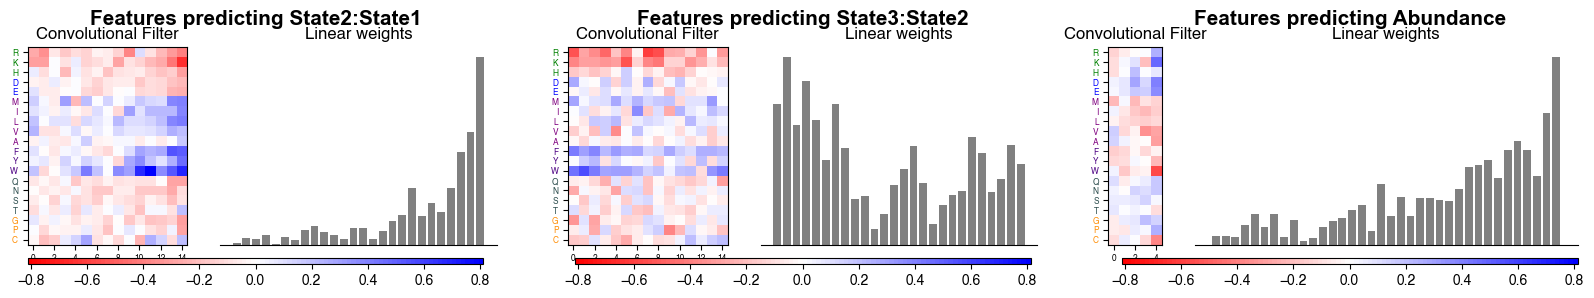

In [ ]:
num_rows = 1

# Get the max value for the heatmaps
models = [three_state_biophysical_model]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())
    conv_weights += list(get_conv_weights(model, "conv2.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(20, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}

# We add in "padding" rows between the rows we care about
height_ratios = [.01] + [3.3]*num_rows + [.1]

# Create a gridspec object for the title 
gs1 = gridspec.GridSpec(2 + num_rows, 3, width_ratios=[1,1,1], height_ratios=height_ratios, figure=fig)

# Title for the K1 parameters
ax1 = plt.subplot(gs1[0,0])
ax1.set_title("Features predicting State2:State1", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

# Title for the K2 parameters
ax2 = plt.subplot(gs1[0,1])
ax2.set_title("Features predicting State3:State2", fontdict=title_font)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.patch.set_visible(False)
ax2.axis('off')

# Title for the abundance parameters
ax3 = plt.subplot(gs1[0,2])
ax3.set_title("Features predicting Abundance", fontdict=title_font)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.patch.set_visible(False)
ax3.axis('off')

# Plot the parameters in a single row
ax1, ax2, ax3, ax4, ax5, ax6, im1, im2, im3 = make_row_plot_abund(fig, kernel_size_three, three_state_biophysical_model, 1, lim, height_ratios, num_rows, abund_k_three)

# Add titles
ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)
ax3.set_title("Convolutional Filter", fontsize=12)
ax4.set_title("Linear weights", fontsize=12)
ax5.set_title("Convolutional Filter", fontsize=12)
ax6.set_title("Linear weights", fontsize=12)

# Create gridspec object for the colorbar
gs_cb = gridspec.GridSpec(2 + num_rows, 3, width_ratios=[1,1,1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[1 + num_rows,0])
cax2 = plt.subplot(gs_cb[1 + num_rows,1])
cax3 = plt.subplot(gs_cb[1 + num_rows,2])

# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')
fig.colorbar(im2, cax=cax2, orientation='horizontal')
fig.colorbar(im3, cax=cax3, orientation='horizontal')

plt.savefig('figures/three_state_parameters.pdf', dpi=1000, bbox_inches='tight')